In [1]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

Welcome to JupyROOT 6.24/06


In [2]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "20211115-8corespernode-nopinning"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    nodes = int(timedir.split("_")[2].replace("nodes",""))
    corespernode = int(timedir.split("_")[3].replace("corespernode",""))
    chunks = nodes*corespernode
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = int(f.split("_")[1].replace("task",""))
        df["taskid"] = int(taskid)
        df["nodes"] = int(nodes)
        df["chunks"] = int(chunks)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by="nodes").reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes,chunks
0,22.808,7631798924,1849,14117594700,6,1,8
1,24.270,9482507924,1488,14117594700,1,1,8
2,23.460,9993907437,1412,14117594700,1,1,8
3,26.744,9107089664,1550,14117594700,1,1,8
4,23.648,9300317836,1517,14117594700,1,1,8
...,...,...,...,...,...,...,...
1507,5.839,5236897199,449,2352932472,19,6,48
1508,5.282,4680214850,502,2352932472,19,6,48
1509,5.446,4601611218,511,2352932472,19,6,48
1510,5.634,5158741796,456,2352932472,22,6,48


In [3]:
meantaskthroughput = df.groupby(["chunks"]).mean()
meantaskthroughput = meantaskthroughput.reset_index().sort_values("chunks").reset_index(drop=True)
meantaskthroughput


,chunks,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes
0,8,24.589778,8.750807e+09,1635.138889,1.411759e+10,3.5,1.0
1,16,13.610285,9.683105e+09,752.083333,7.058797e+09,7.5,2.0
2,24,9.924477,8.499068e+09,556.819444,4.705865e+09,11.5,3.0
3,32,7.218573,5.949659e+09,595.607639,3.529399e+09,15.5,4.0
4,40,6.161328,5.259723e+09,539.738889,2.823519e+09,19.5,5.0
5,48,5.516734,4.829797e+09,489.414352,2.352932e+09,23.5,6.0


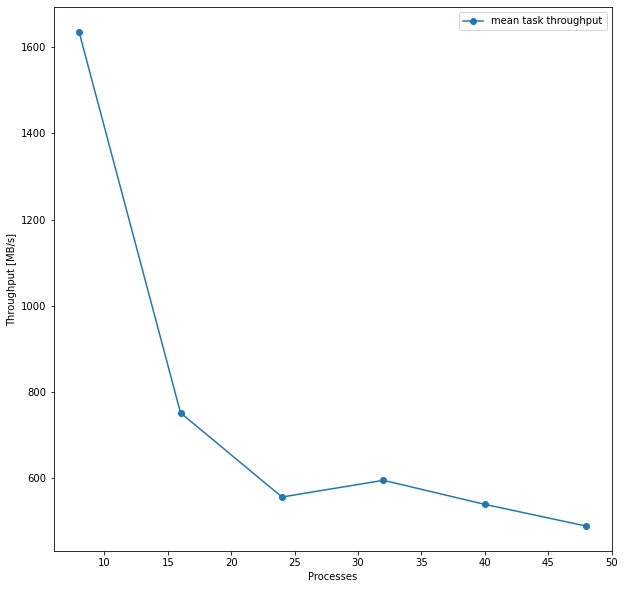

In [4]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["chunks"], meantaskthroughput["readthroughput"], label="mean task throughput", marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

In [5]:
sumthroughput = df.groupby(["chunks","nodes","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["chunks","nodes"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / 1024
sumthroughput

,chunks,nodes,taskid,taskruntime,taskreadtime,readthroughput,readpayload,totalthroughput
0,8,1,28,196.718222,7.000645e+10,13081.111111,1.129408e+11,12.774523
1,16,2,120,217.764556,1.549297e+11,12033.333333,1.129408e+11,11.751302
2,24,3,276,238.187444,2.039776e+11,13363.666667,1.129408e+11,13.050456
3,32,4,496,230.994333,1.903891e+11,19059.444444,1.129408e+11,18.612739
4,40,5,780,246.453111,2.103889e+11,21589.555556,1.129408e+11,21.083550
5,48,6,1128,264.803222,2.318303e+11,23491.888889,1.129408e+11,22.941298


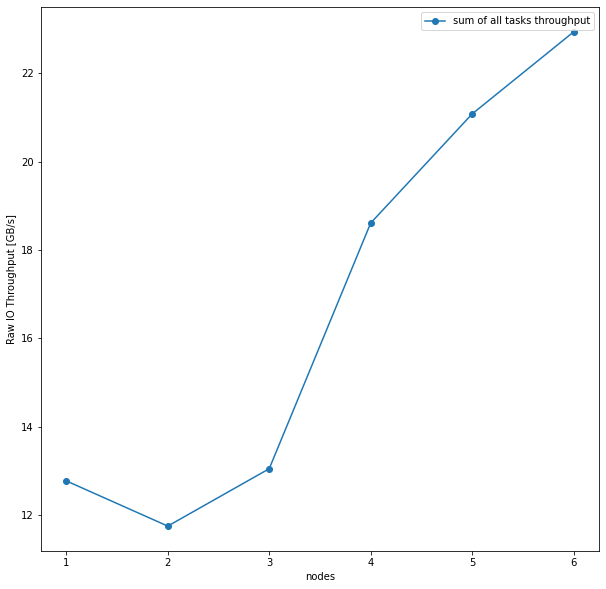

In [6]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["nodes"], sumthroughput["totalthroughput"], label="sum of all tasks throughput", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Raw IO Throughput [GB/s]")
pyplot.legend()

# Python timer

In [11]:
times = {"nodes":[],"meanruntime":[], "err":[], "throughput_MB_s":[]}
timedir = "20211115-8corespernode-nopinning/appruntimes"
datasetsize = 157400503680
readpercent = 0.7949011466389114
readsize = datasetsize * readpercent # taken from the RNTuple metrics above

for f in os.listdir(timedir):
    array = numpy.genfromtxt(os.path.join(timedir, f), skip_header=2)
    nodes = f.split("_")[5].replace("nodes","")
    time_mean = numpy.mean(array)
    times["nodes"].append(int(nodes))
    times["meanruntime"].append(round(time_mean, 2))
    times["err"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_MB_s"].append(round(readsize/time_mean/pow(10,6)))
    
timesdf = pandas.DataFrame(times)
timesdf = timesdf.sort_values(by="nodes").reset_index(drop=True).copy()
throughput_1node = timesdf["throughput_MB_s"][0]
time_1node = timesdf["meanruntime"][0]
timesdf["runtimespeedup"] = time_1node / timesdf["meanruntime"]
timesdf["throughputspeedup"] = timesdf["throughput_MB_s"] / throughput_1node
timesdf

,nodes,meanruntime,err,throughput_MB_s,runtimespeedup,throughputspeedup
0,1,26.51,0.45,4719,1.000000,1.000000
1,2,14.84,0.23,8430,1.786388,1.786395
2,3,10.62,0.13,11776,2.496234,2.495444
3,4,7.94,0.07,15763,3.338791,3.340326
4,5,6.76,0.08,18508,3.921598,3.922017
5,6,6.08,0.12,20573,4.360197,4.359610


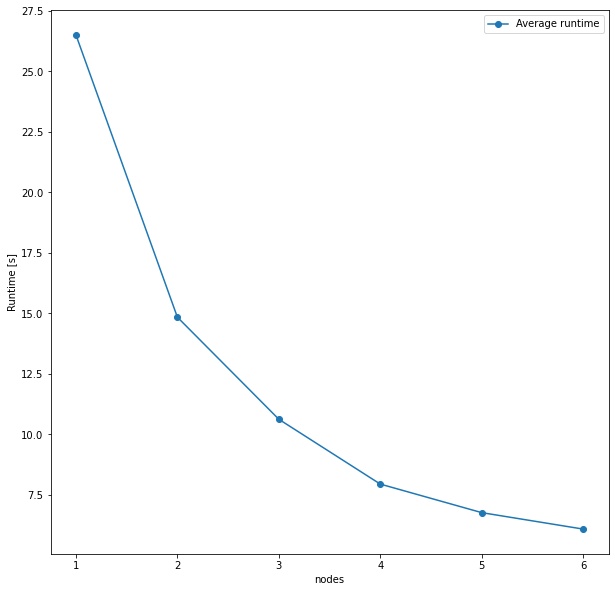

In [12]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["meanruntime"], label="Average runtime", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Runtime [s]")
pyplot.legend()

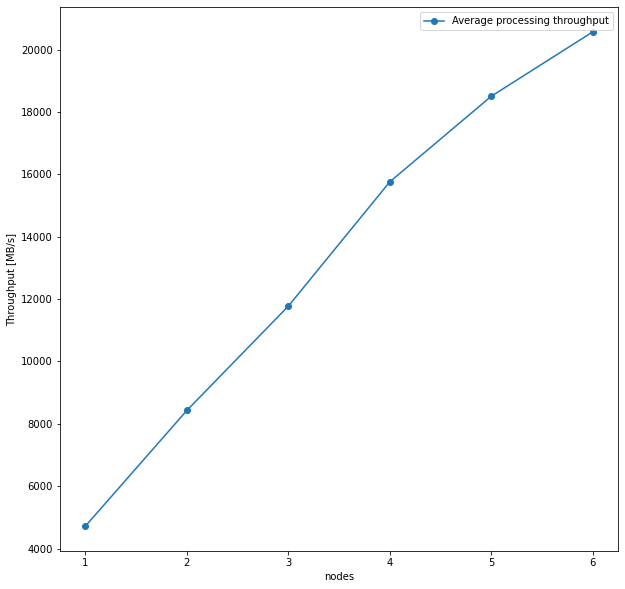

In [13]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughput_MB_s"], label="Average processing throughput", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

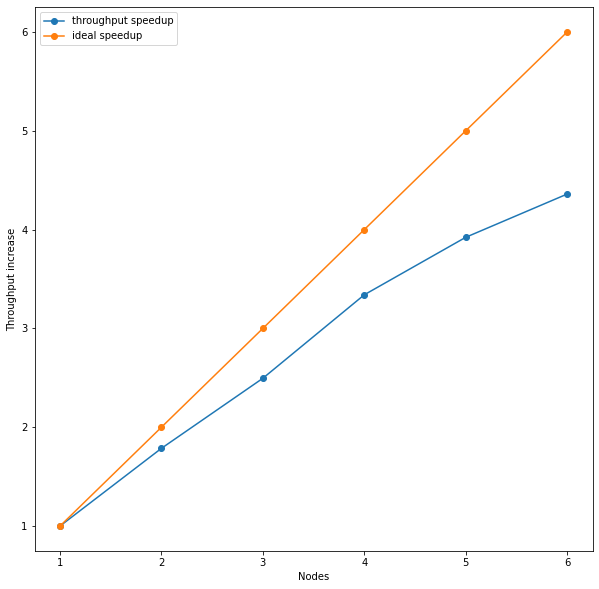

In [14]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughputspeedup"], label="throughput speedup", marker="o")
pyplot.plot(timesdf["nodes"], timesdf["nodes"], label="ideal speedup", marker="o")
pyplot.xticks(timesdf["nodes"])
pyplot.yticks(timesdf["nodes"])
pyplot.xlabel("Nodes")
pyplot.ylabel("Throughput increase")
pyplot.legend()